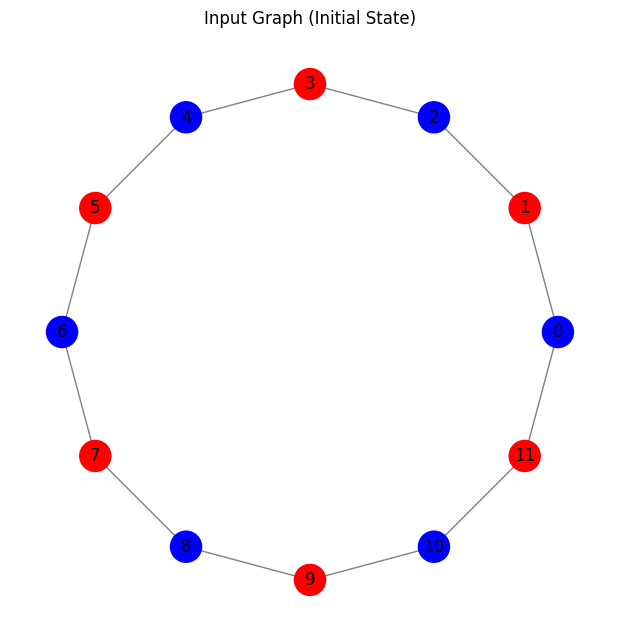

Epoch 1/1500, Loss: 0.7708
Epoch 101/1500, Loss: 0.0069
Epoch 201/1500, Loss: 0.0025
Epoch 301/1500, Loss: 0.0022
Epoch 401/1500, Loss: 0.0020
Epoch 501/1500, Loss: 0.0019
Epoch 601/1500, Loss: 0.0018
Epoch 701/1500, Loss: 0.0018
Epoch 801/1500, Loss: 0.0018
Epoch 901/1500, Loss: 0.0018
Epoch 1001/1500, Loss: 0.0017
Epoch 1101/1500, Loss: 0.0017
Epoch 1201/1500, Loss: 0.0017
Epoch 1301/1500, Loss: 0.0017
Epoch 1401/1500, Loss: 0.0017
Accuracy: 100.00%


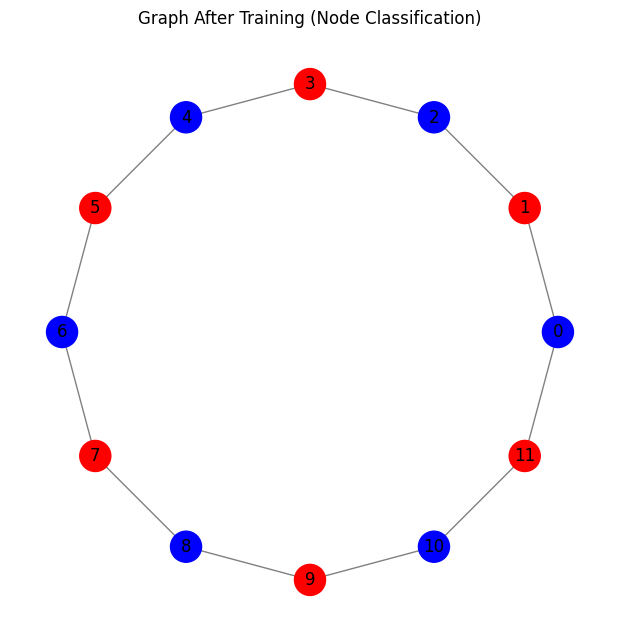

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, BatchNorm
import matplotlib.pyplot as plt
import networkx as nx

# Step 1: Create a circular graph with 12 nodes
num_nodes = 12
edge_index = torch.tensor(
    [[i, (i + 1) % num_nodes] for i in range(num_nodes)] + [[(i + 1) % num_nodes, i] for i in range(num_nodes)],
    dtype=torch.long
).T

# Node features (One-hot encoding for better differentiation)
x = torch.eye(num_nodes, dtype=torch.float)

# Labels for nodes (binary classification, alternating labels)
y = torch.tensor([i % 2 for i in range(num_nodes)], dtype=torch.long)

# Create a PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Step 2: Define the GCN Model
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.bn1 = BatchNorm(16)
        self.conv2 = GCNConv(16, 16)
        self.bn2 = BatchNorm(16)
        self.conv3 = GCNConv(16, out_channels)

    def forward(self, data):
        x = F.relu(self.bn1(self.conv1(data.x, data.edge_index)))
        x = F.relu(self.bn2(self.conv2(x, data.edge_index)))
        x = self.conv3(x, data.edge_index)
        return x

# Step 3: Instantiate the model, define loss and optimizer
model = GCN(in_channels=num_nodes, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()

# Step 4: Training the model
def train(model, data, optimizer, criterion, scheduler, epochs=1500):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Function to visualize the circular graph
def visualize_graph(data, title, labels=None, predictions=None):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())
    pos = nx.circular_layout(G)
    
    plt.figure(figsize=(6, 6))
    node_colors = ["r" if (predictions[i] if predictions is not None else labels[i]) == 1 else "b" for i in range(data.num_nodes)]
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=500)
    plt.title(title)
    plt.show()

# Visualize the graph before training
visualize_graph(data, "Input Graph (Initial State)", labels=data.y)

# Train the model
train(model, data, optimizer, criterion, scheduler)

# Step 5: Evaluate the model
model.eval()
with torch.no_grad():
    out = model(data)
    _, pred = out.max(dim=1)
    accuracy = (pred == data.y).sum().item() / data.num_nodes
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Visualize the graph after training
visualize_graph(data, "Graph After Training (Node Classification)", predictions=pred)
